# Project 3
## Task 4: Unsupervised Anomaly Detection and Interpretation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import random
import torch

In [2]:
# ============================================================================
# REPORT-COMPLIANT PLOT CONFIGURATION
# ============================================================================
# Set consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# Global matplotlib parameters for report-quality figures
plt.rcParams.update({
    # Figure size (width, height) in inches - suitable for reports
    'figure.figsize': (8, 5),
    'figure.dpi': 150,

    # Font sizes
    'font.size': 17,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'legend.title_fontsize': 17,

    # Font weight
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',

    # Line widths
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,

    # Grid style
    'grid.alpha': 0.3,
    'grid.linestyle': '--',

    # Save figure settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistency
REPORT_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'normal': '#2E86AB',
    'anomaly': '#F18F01'
}
# ============================================================================

### Helper functions

In [3]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = True
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task4'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 4 plots directory.

    Args:
        filename: Target filename such as 'task4_kmeans_silhouette.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [5]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

### Load the datasets

In [6]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [7]:
all_labels = ['dos', 'normal', 'probe', 'r2l']

In [8]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

### K-Means
First, we define some helper functions to compute the SSE, the silhouette, and to plot the attack label distribution in the clusters.

In [9]:
# Function to compute SSE (Sum of Squared Errors)
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels, filename=None):

    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1

    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 5))

    y_lower = 10
    colors = ["#00796B", "#d95f02", "#875692", "#00ACC1"]

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i]
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=15, fontweight='bold')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax.set_title("Silhouette Plot for Various Clusters", pad=15)
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Average: {silhouette_avg:.3f}')
    ax.legend()

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.tight_layout()

    if filename:
        save_figure_for_report(filename)
    plt.show()
    plt.close()

In [10]:
def plot_attack_label_distribution_by_cluster(cluster_labels, attack_labels, top_n=None, normalize=False, filename=None):
    classes = ['dos', 'normal', 'probe', 'r2l']
    data = pd.DataFrame({"cluster": cluster_labels, "attack_label": attack_labels})
    dist = pd.crosstab(data["cluster"], data["attack_label"])

    if top_n is not None and top_n < dist.shape[1]:
        top_cols = dist.sum().sort_values(ascending=False).head(top_n).index
        other = dist.drop(columns=top_cols).sum(axis=1)
        dist = dist[top_cols]
        dist["Other"] = other

    plot_df = dist.div(dist.sum(axis=1), axis=1) * 100 if normalize else dist
    unit = "%" if normalize else "count"

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_df.plot(kind="bar", stacked=True, ax=ax, color=["#1565C0", "#e41a1c", "#FFA000", "#4daf4a"])
    #ax.set_title("Attack Label Distribution Across Clusters", pad=15)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Attack Label Share ({unit})")
    plt.xticks(rotation=0)
    ax.legend(title="Attack Label", labels=classes)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()

    if filename:
        save_figure_for_report(filename)
    plt.show()

### K-means cluster interpretation
Create 4 clusters with K-means using different seeds.

K-Means SSE: 480336.73
K-Means Silhouette Score: 0.48
For n_clusters = 4 The average silhouette_score is : 0.475377234236548
cluster 0 size 15099
cluster 1 size 1777
cluster 2 size 1806
cluster 3 size 149
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs7.png


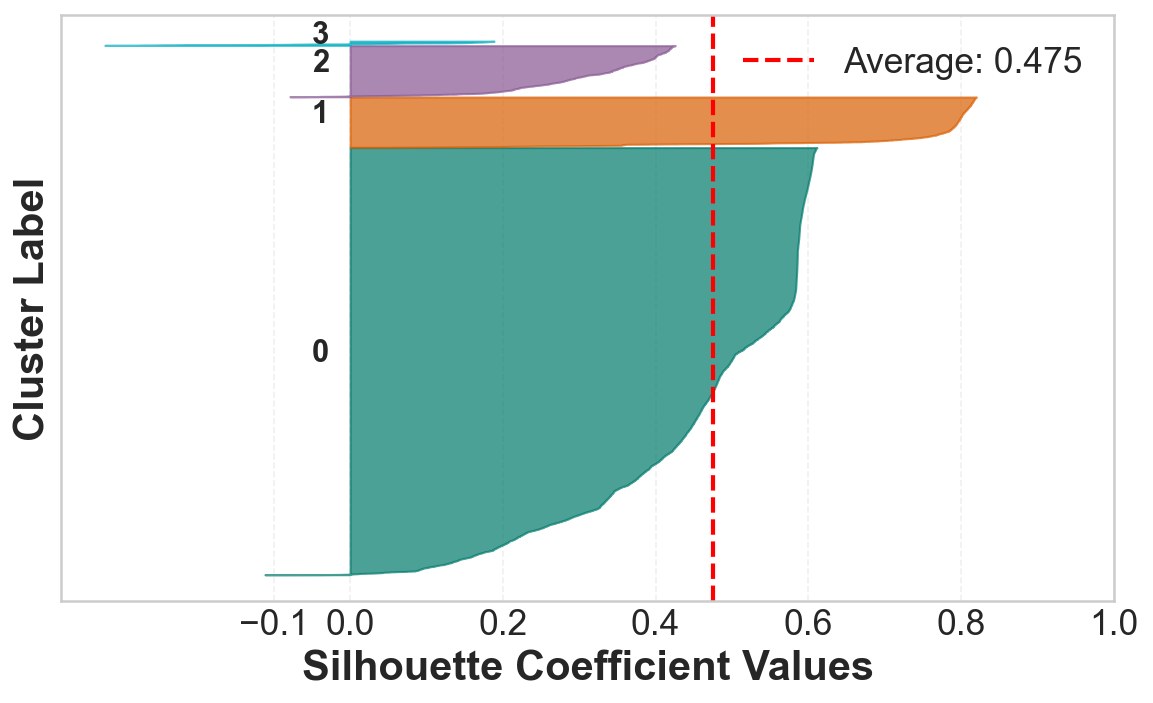

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs7.png


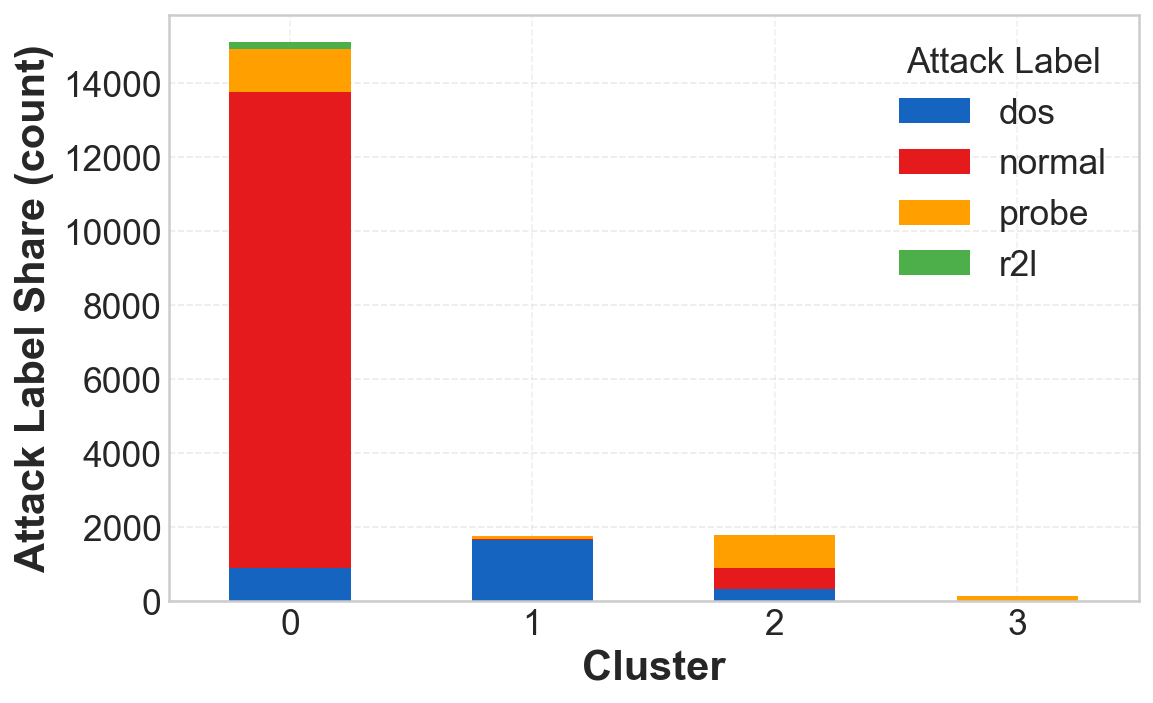

K-Means SSE: 508409.58
K-Means Silhouette Score: 0.22
For n_clusters = 4 The average silhouette_score is : 0.21845917622446895
cluster 0 size 1953
cluster 1 size 11773
cluster 2 size 5095
cluster 3 size 10
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs21.png


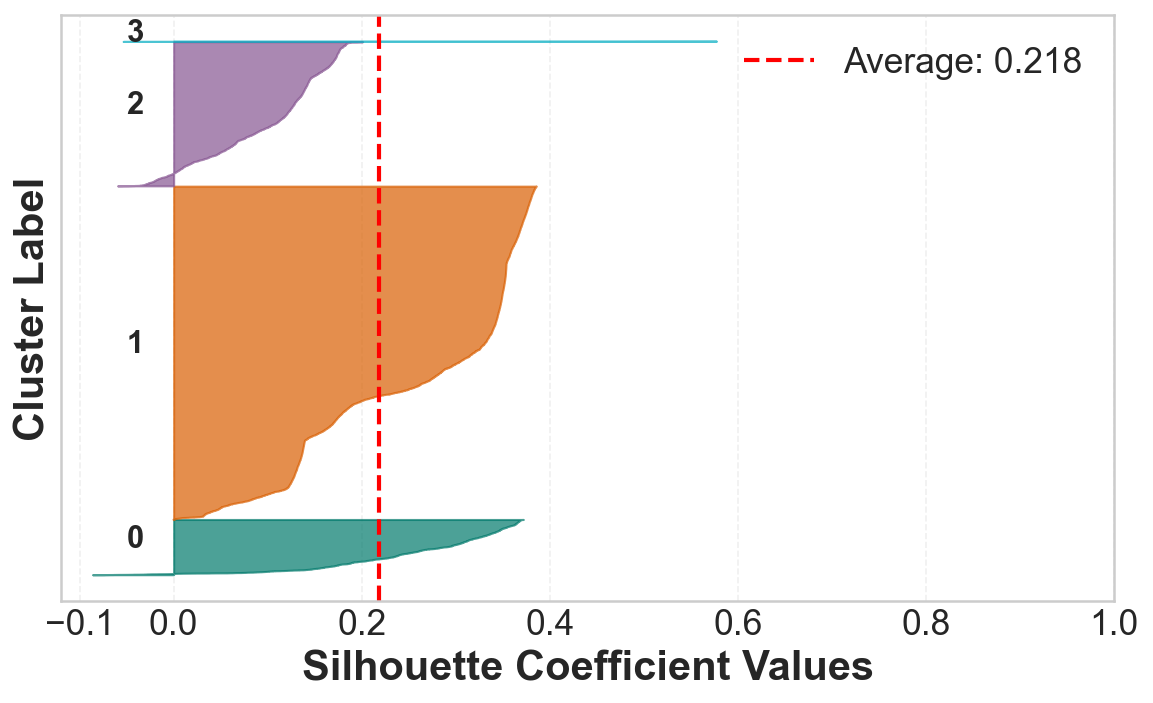

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs21.png


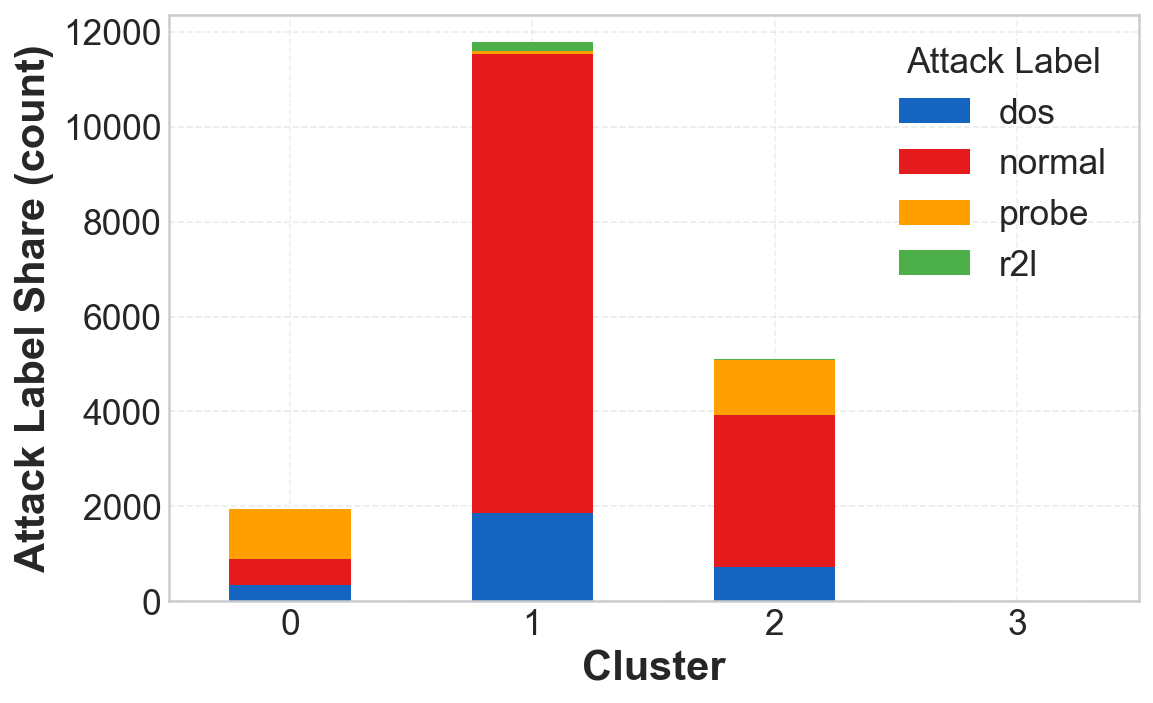

K-Means SSE: 514973.18
K-Means Silhouette Score: 0.41
For n_clusters = 4 The average silhouette_score is : 0.40743872102296397
cluster 0 size 17040
cluster 1 size 1
cluster 2 size 8
cluster 3 size 1782
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs111.png


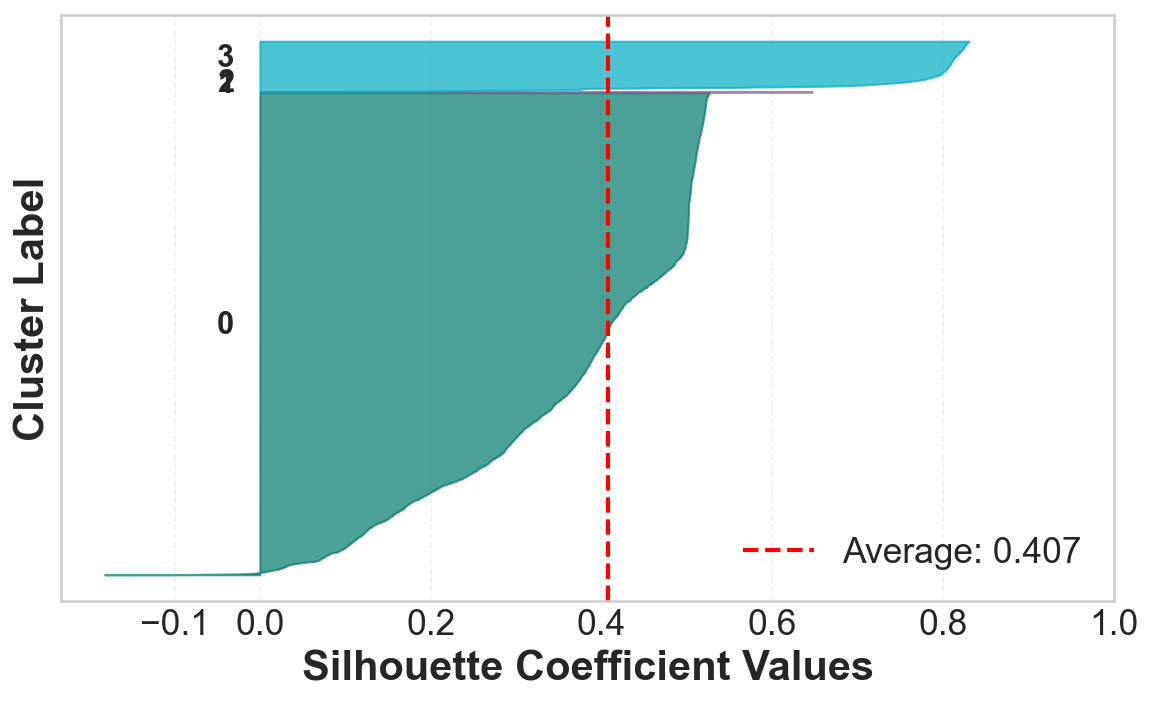

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs111.png


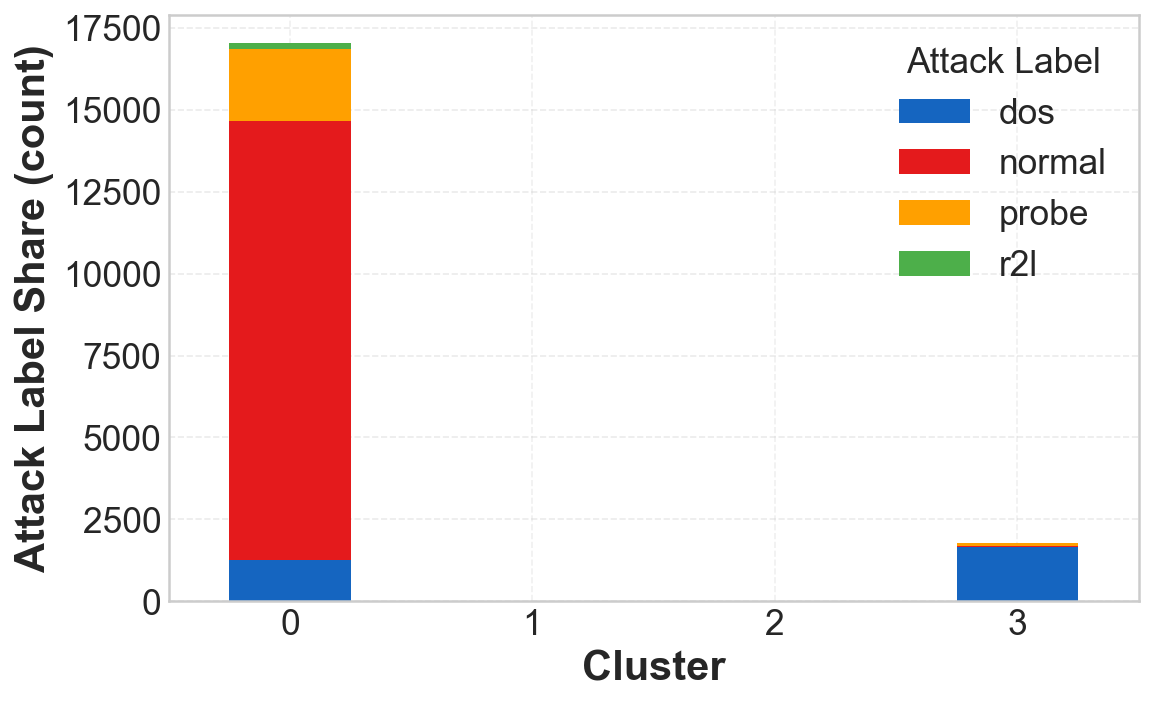

K-Means SSE: 467961.01
K-Means Silhouette Score: 0.35
For n_clusters = 4 The average silhouette_score is : 0.34613494846146664
cluster 0 size 10647
cluster 1 size 1782
cluster 2 size 4472
cluster 3 size 1930
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs42.png


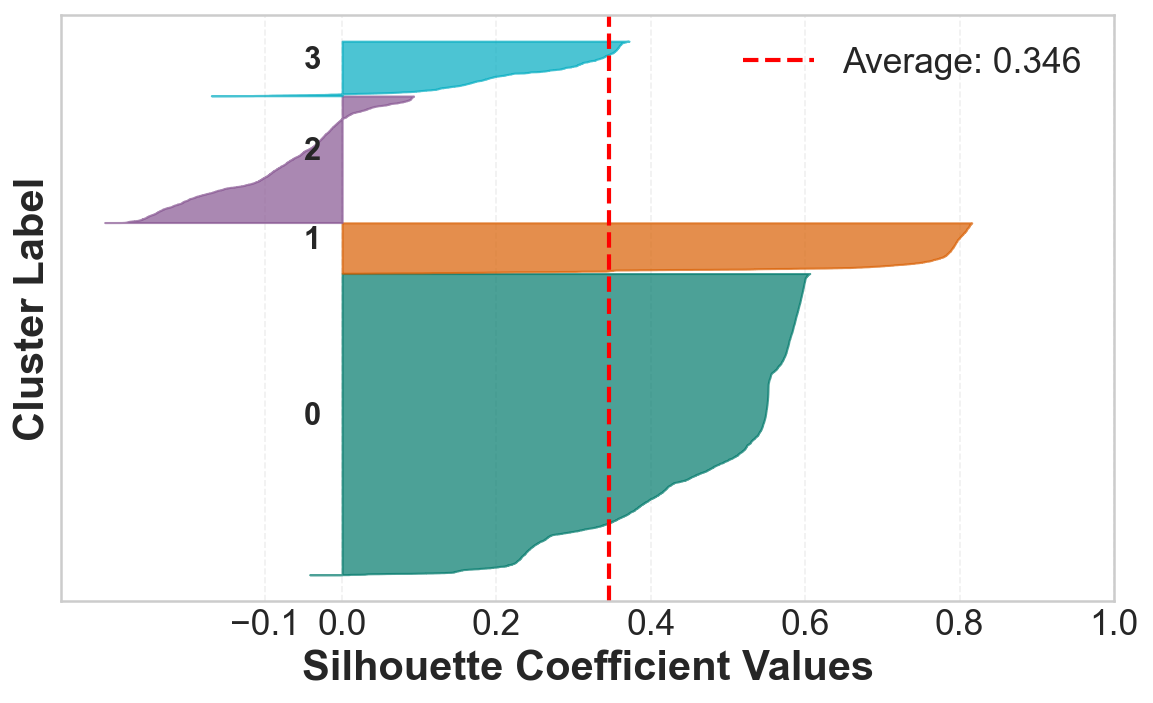

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs42.png


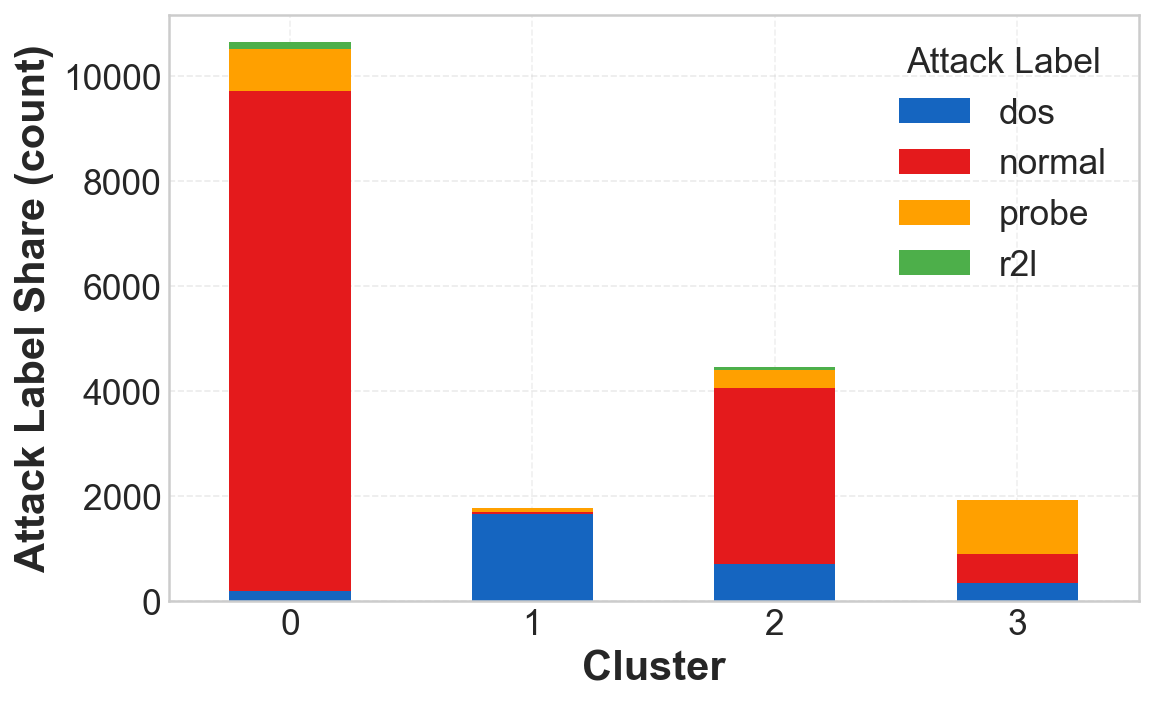

In [11]:
for idx, random_state in enumerate([7, 21, 111, 42]):
    # Set number of clusters
    kmeans = KMeans(n_clusters=4, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(X_train)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_

    sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
    silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

    print(f"K-Means SSE: {sse_avg:.2f}")
    print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
    plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels, filename=f'task4_kmeans_silhouette_rs{random_state}.png')

    plot_attack_label_distribution_by_cluster(cluster_labels, y_original_train, top_n=8, normalize=False, filename=f'task4_kmeans_attack_distribution_rs{random_state}.png')

### Question 1: Cluster Analysis
**Q: How big are the clusters? How are the attack labels distributed across the clusters? Are the clusters pure (i.e., they consist of only one attack label)?**

**Answer:**
- **Cluster Sizes:**
    - cluster 0 size 10647
    - cluster 1 size 1782
    - cluster 2 size 4472
    - cluster 3 size 1930
- **Distribution:** The stacked bar charts show the composition of each cluster.
- **Purity:**
    - Ideally, we want clusters to be 100% one class.
    - **Observation:** We see some clusters that are predominantly **Normal** and others that capture **DoS** or **Probe**.

Results summary.

In [12]:
silhouette_avg, cluster_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

cluster_silhouette_df = (
    pd.DataFrame({
        "cluster": list(cluster_silhouettes.keys()),
        "silhouette": list(cluster_silhouettes.values())
    })
    .sort_values("silhouette", ascending=False)
    .reset_index(drop=True)
)

print(cluster_silhouette_df)

attack_dist = (
    pd.DataFrame({"cluster": kmeans_labels, "attack_label": [all_labels[l] for l in y_original_train]})
    .groupby("cluster")["attack_label"]
    .value_counts()
    .rename("count")
    .reset_index()
)

merged = cluster_silhouette_df.merge(attack_dist, on="cluster", how="left")
print("\nAttack labels inside clusters:")
print(merged.sort_values(["silhouette", "count"], ascending=[True, False]))

print("\nSamples with silhouette < 0 in clusters:")
print(pd.DataFrame({'cluster': kmeans_labels, 'silhouette': sample_silhouette_values}).groupby('cluster')['silhouette'].apply(lambda x: (x < 0).sum()))


   cluster  silhouette
0        1    0.737148
1        0    0.478635
2        3    0.246781
3        2   -0.082254

Attack labels inside clusters:
    cluster  silhouette attack_label  count
11        2   -0.082254       normal   3339
12        2   -0.082254          dos    717
13        2   -0.082254        probe    357
14        2   -0.082254          r2l     59
8         3    0.246781        probe   1036
9         3    0.246781       normal    551
10        3    0.246781          dos    343
4         0    0.478635       normal   9518
5         0    0.478635        probe    812
6         0    0.478635          dos    196
7         0    0.478635          r2l    121
0         1    0.737148          dos   1657
1         1    0.737148        probe     84
2         1    0.737148       normal     40
3         1    0.737148          r2l      1

Samples with silhouette < 0 in clusters:
cluster
0       3
1       0
2    3671
3      66
Name: silhouette, dtype: int64


### Question 2: Silhouette Analysis
**Q: How high is the silhouette per cluster? Is there any clusters with a lower silhouette value? If it is the case, what attack labels are present in these clusters?**

**Answer:**
- **Silhouette Scores:** 
    - cluster 1: 0.737148
    - cluster 0: 0.478635
    - cluster 3: 0.246781
    - cluster 2: -0.082254
- **Low Silhouette Clusters:** Clusters with below-average silhouette scores are likely "muddy" or overlapping with other clusters (e.g., cluster 2)
- **Content of Low Silhouette Clusters:** All types of attacks.

### TSNE
We try to use TSNE with different perplexity values: 5, 30, 100.

In [13]:
def plot_tsne(df, cluster_labels, perplexity=30, filename=None, title="Cluster", palette=None):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    print(f"\nGenerating t-SNE plot with perplexity={perplexity}...")

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df)
    labels = cluster_labels

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    # Set default palettes if not provided
    if palette is None:
        palette = ["#00796B", "#d95f02", "#875692", "#00ACC1"] if title == "Cluster" else ["#1565C0", "#FFA000", "#e41a1c", "#4daf4a"]

    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette=palette, alpha=0.7, s=30
    )

    #plt.title(f'2D t-SNE Projection (perplexity={perplexity})', pad=15)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    # Get current legend and recreate with white background
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(handles, labels, title=title, facecolor='white', edgecolor='white', framealpha=0.5, frameon=True, fontsize=16, handletextpad=0.4, markerscale=1.5)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()

    if filename:
        save_figure_for_report(filename)
    plt.show()

    return


Generating t-SNE plot with perplexity=5...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_5.png


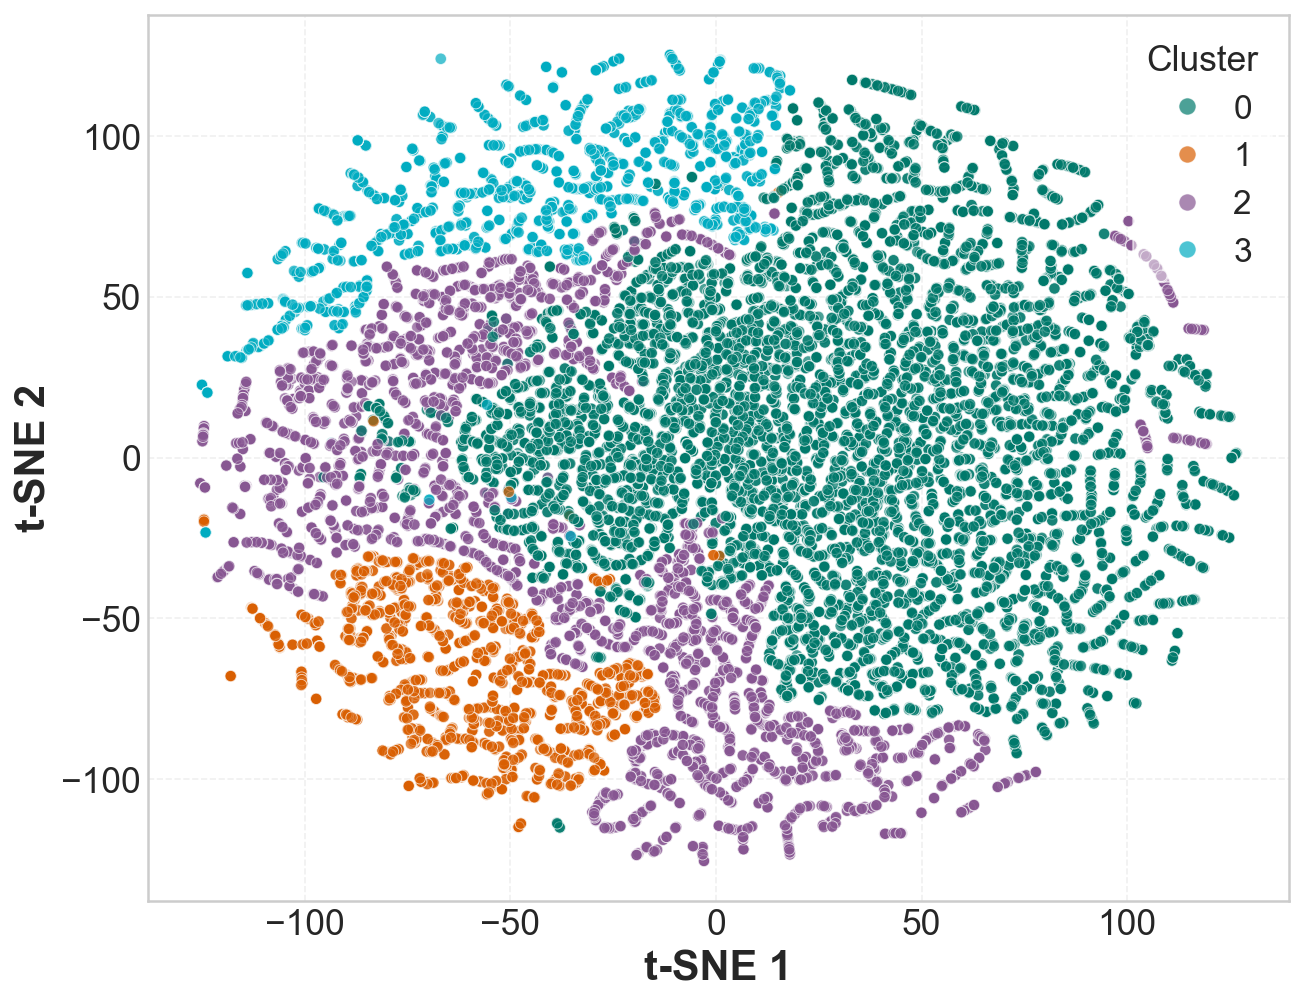


Generating t-SNE plot with perplexity=30...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_30.png


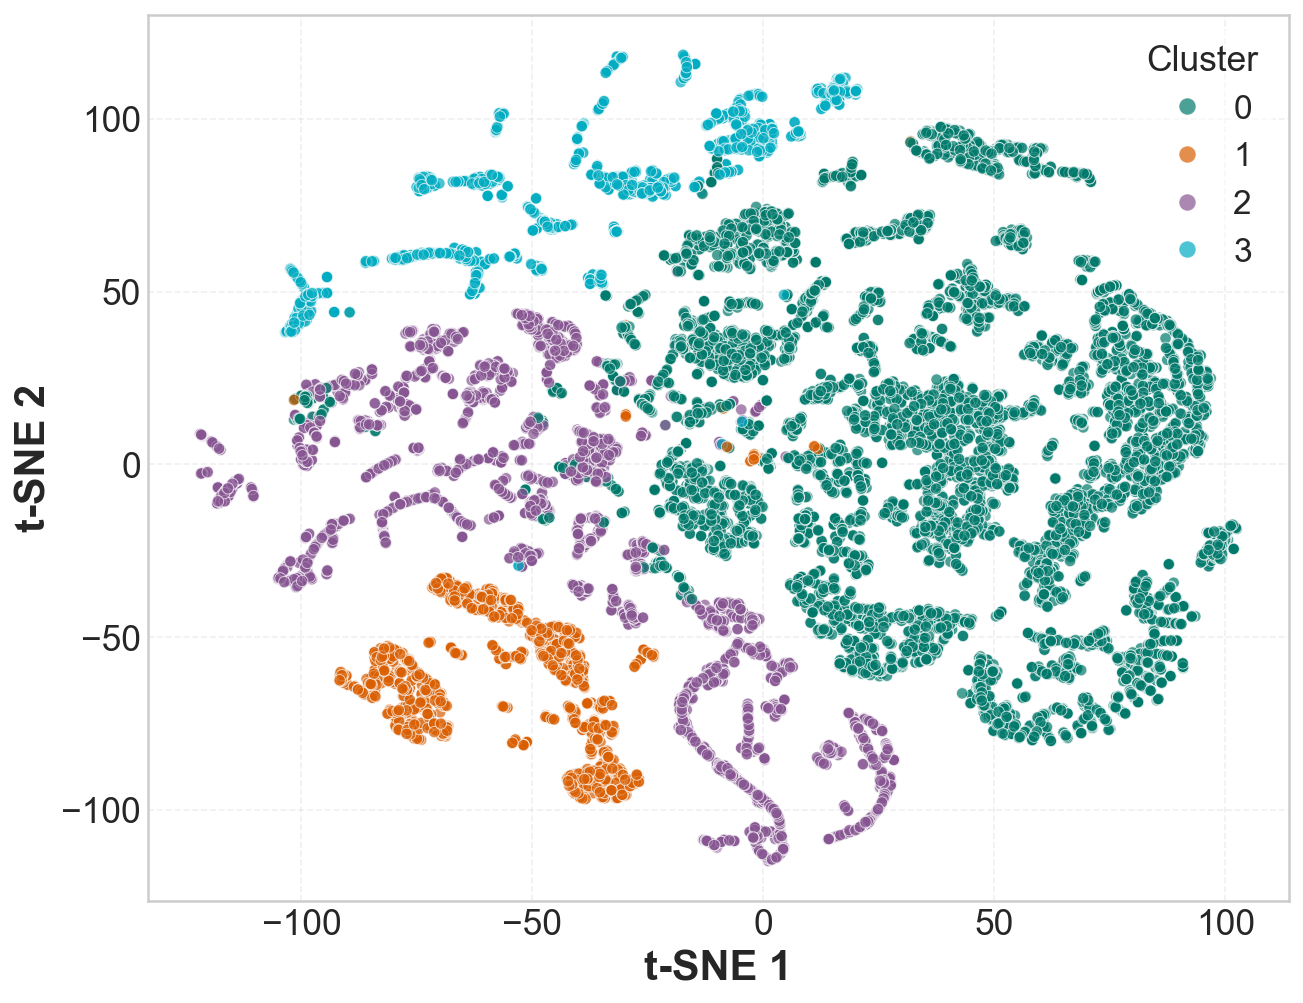


Generating t-SNE plot with perplexity=100...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_100.png


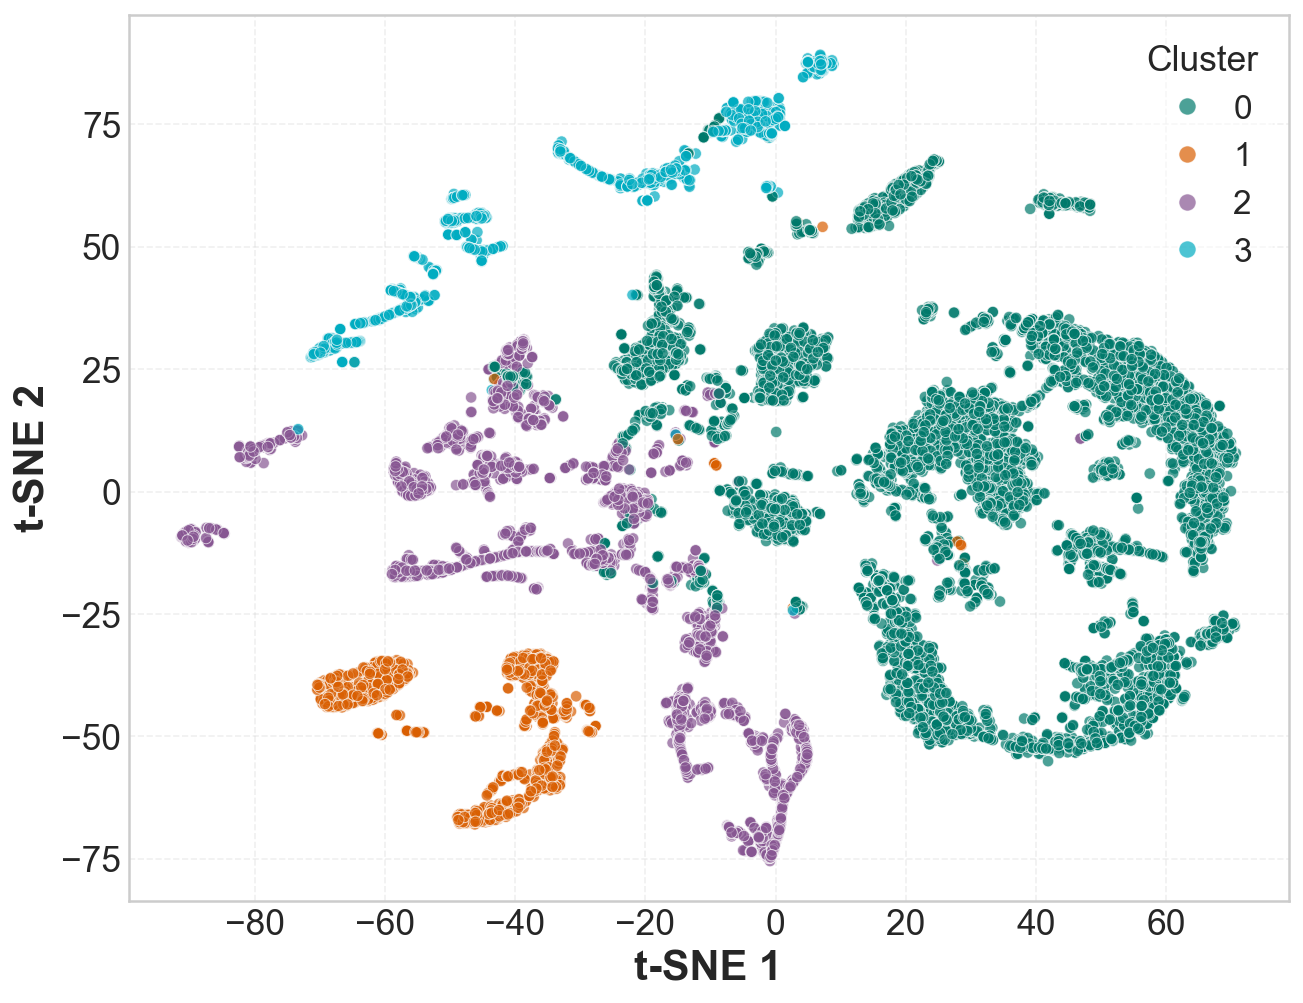

In [14]:
for perplexity in [5, 30, 100]:
    plot_tsne(X_train, kmeans_labels, perplexity=perplexity, filename=f'task4_tsne_kmeans_perplexity_{perplexity}.png')


Generating t-SNE plot with perplexity=30...
Figure saved to: ../Plots/Task4/task4_tsne_true_labels_perplexity_30.png


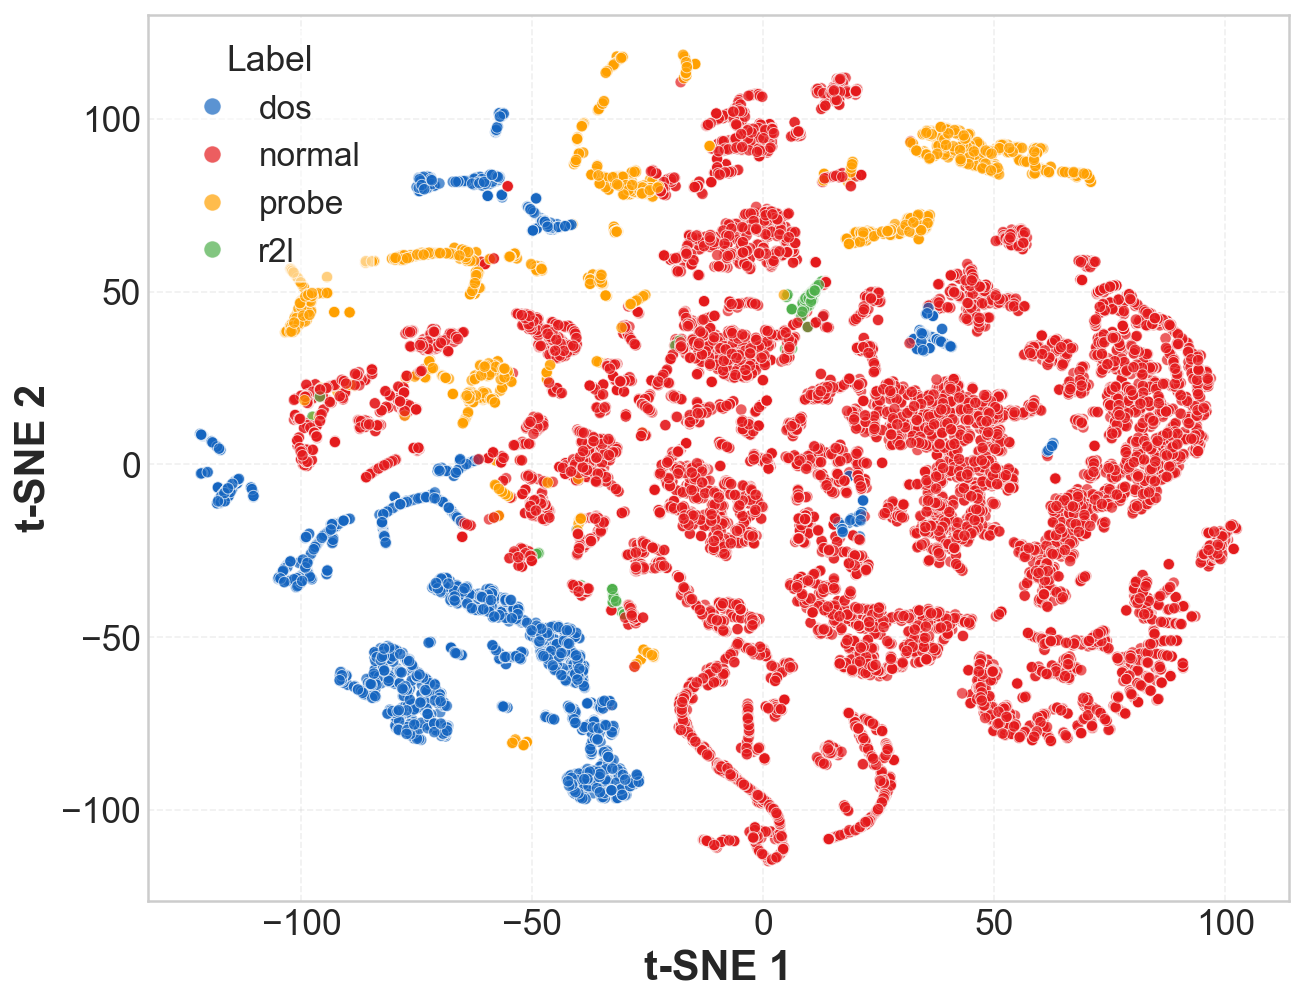

In [15]:
label_map = {0: 'dos', 1: 'normal', 2: 'probe', 3: 'r2l'}
label_names = df_train['label'].map(label_map)
plot_tsne(X_train, list(label_names), perplexity=30, filename='task4_tsne_true_labels_perplexity_30.png', title="Label")

### Question 3: t-SNE Visualization
**Q: Use the t-SNE algorithm to obtain a 2D visualization of your points. Plot and report: i) t-SNE using all training data and as label the cluster ID... ii) Use the t-SNE with the best-looking perplexity and plot all training data with the attack label. Can you find a difference between the two visualizations? What are the misinterpreted points?**

**Answer:**
- **Visualizations:** The plots above show the data projected into 2D.
- **Difference:**
    - The **Cluster ID plot** shows distinct, separated regions (because K-Means forces this partition).
    - The **True Label plot** shows the actual distribution.
- **Misinterpretation:** By comparing the two, we can see where K-Means "cut" through a continuous manifold of a single class (splitting it into two clusters) or where it merged two distinct classes into one cluster. Points that are close in t-SNE but have different true labels are the ones K-Means likely misclassified or grouped together incorrectly.

## DB-SCAN

First, we try to estimate min_points evaluating the k-means result and looking for the smallest cluster that consists only of normal data.

In [16]:
for c in range(5,10):
    print(f"\n{c} CLUSTERS")
    # Set number of clusters
    kmeans = KMeans(n_clusters=c, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_train)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_

    # Create a dataframe with cluster assignments and attack labels
    data = pd.DataFrame({
        "cluster": kmeans_labels,
        "attack_label": [all_labels[l] for l in y_original_train]
    })

    # Group by cluster and get unique attack labels + cluster size
    cluster_info = data.groupby("cluster").agg({
        "attack_label": lambda col: np.sort(col.unique()).tolist(),
        "cluster": "size"  # This gets the cluster size
    }).rename(columns={"cluster": "size"})

    print("All Cluster Sizes:")
    print(cluster_info.sort_values("size", ascending=False))


5 CLUSTERS
All Cluster Sizes:
                      attack_label   size
cluster                                  
0        [dos, normal, probe, r2l]  10312
2        [dos, normal, probe, r2l]   2905
3             [dos, normal, probe]   1921
4             [dos, normal, probe]   1920
1        [dos, normal, probe, r2l]   1773

6 CLUSTERS
All Cluster Sizes:
                      attack_label  size
cluster                                 
0                    [dos, normal]  8811
2        [dos, normal, probe, r2l]  3503
3             [dos, normal, probe]  1919
4             [dos, normal, probe]  1919
1        [dos, normal, probe, r2l]  1772
5             [normal, probe, r2l]   907

7 CLUSTERS
All Cluster Sizes:
                      attack_label  size
cluster                                 
0                    [dos, normal]  8812
2        [dos, normal, probe, r2l]  3500
3             [dos, normal, probe]  1919
4             [dos, normal, probe]  1919
1        [dos, normal, probe, r2l]  177

With 8 or 9 clusters, we find that the smallest cluster containing only normal data has 10 elements.

This number is very small and, following a suggestion of the professor, we try to compute the cosine distance of all points from their k^th neighbor (we consider the first 3000).

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

X = X_train.values.astype(float)
cosine_matrix = cosine_similarity(X)


In [18]:
sorted_cosine_matrix = np.sort(-cosine_matrix, axis=1) * (-1)
sorted_cosine_matrix

array([[ 1.        ,  0.99998542,  0.99961678, ..., -0.21436344,
        -0.2154818 , -0.21655176],
       [ 1.        ,  0.99999885,  0.99999697, ..., -0.31736269,
        -0.31911198, -0.32524676],
       [ 1.        ,  0.9999993 ,  0.99997148, ..., -0.41429175,
        -0.41782376, -0.4300536 ],
       ...,
       [ 1.        ,  0.99961984,  0.99893181, ..., -0.57993504,
        -0.58046133, -0.58159841],
       [ 1.        ,  0.9999908 ,  0.99995609, ..., -0.41279847,
        -0.41622029, -0.42832438],
       [ 1.        ,  0.99994637,  0.99988312, ..., -0.54499315,
        -0.54527811, -0.54604595]])

In [19]:
# Take top 3000 neighbours
sorted_cosine_matrix_top = sorted_cosine_matrix[:, :3000]
means = 1 - sorted_cosine_matrix_top.mean(axis=0)

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_selection.png


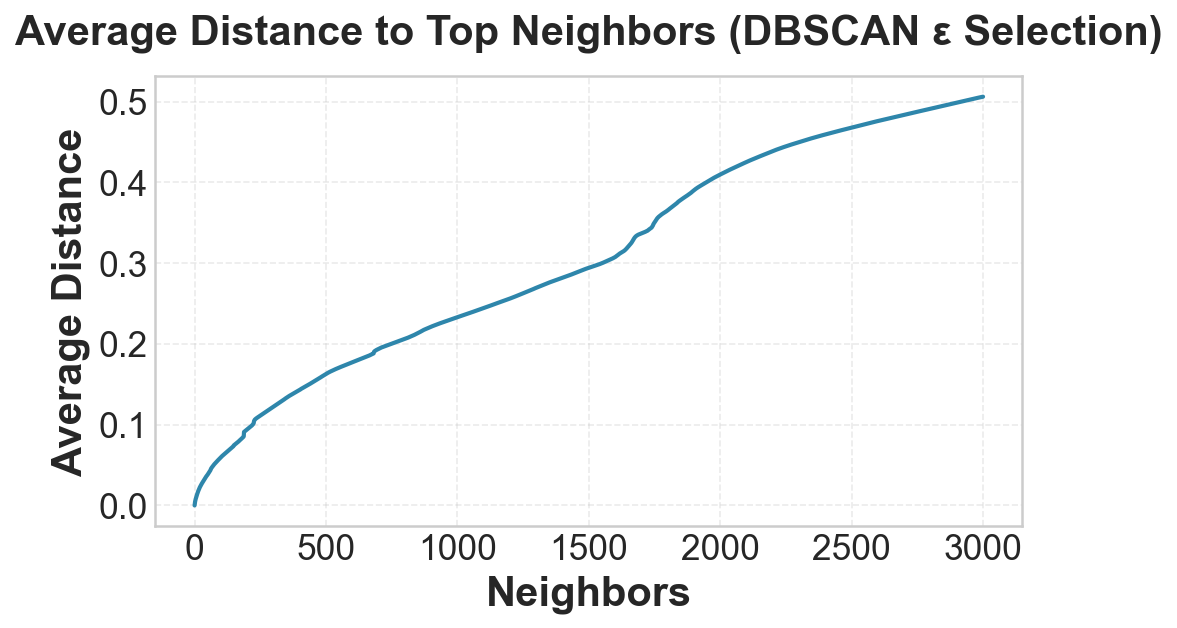

In [20]:
# Plot the mean distance for the top neighobours
plt.figure(figsize=(7, 4.5))
plt.plot(means, linewidth=2, color='#2E86AB')
plt.xlabel('Neighbors')
plt.ylabel('Average Distance')
plt.title('Average Distance to Top Neighbors (DBSCAN ε Selection)', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_selection.png')
plt.show()

From this plot, we can get both min_points and epsilon: there is a sort of elbow near 1600 (min_points) and the distance is 0.32 (epsilon).


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     13448
           1       0.50      0.51      0.50      5383

    accuracy                           0.71     18831
   macro avg       0.65      0.65      0.65     18831
weighted avg       0.72      0.71      0.71     18831

Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v1.png


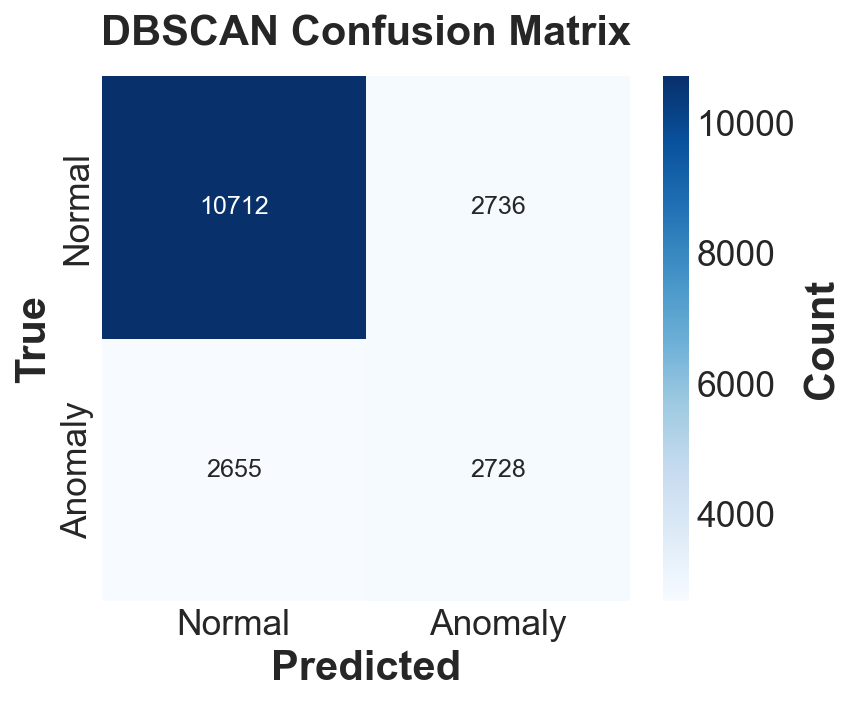

In [21]:
# Use DBSCAN with the epsilon and min_points gotten from the plot
dbscan = DBSCAN(eps=0.32, min_samples=1600, metric="cosine")
dbscan_labels = dbscan.fit_predict(X_train)
y_pred_binary_dbscan = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_train, y_pred_binary_dbscan))
# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_train, y_pred_binary_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('DBSCAN Confusion Matrix', pad=15)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
save_figure_for_report('task4_dbscan_confusion_matrix_v1.png')
plt.show()

Print statistics.

In [22]:
dataset_dbscan = pd.DataFrame()
dataset_dbscan['label'] = df_train['label'].map({0:'dos', 1:'normal', 2:'probe', 3:'r2l'})
dataset_dbscan['binary_label'] = y_train
dataset_dbscan['dbscan_label'] = dbscan_labels

print("Clusters", np.unique(dataset_dbscan['dbscan_label']))

noise = dataset_dbscan[dataset_dbscan['dbscan_label'] == -1]
rest = dataset_dbscan[dataset_dbscan['dbscan_label'] != -1]

clusters = []
clusters.append(dataset_dbscan[dataset_dbscan['dbscan_label'] == 0])
clusters.append(dataset_dbscan[dataset_dbscan['dbscan_label'] == 1])
clusters.append(dataset_dbscan[dataset_dbscan['dbscan_label'] == 2])

total = len(dataset_dbscan)
n_noise = len(noise)

print(f"Noise points: {n_noise} / {total} ({n_noise/total:.2%})\n")

print("Composition by multi-class 'label' in the noise cluster:")
print(noise['label'].value_counts().sort_index())
print("\nComposition by 'label' (percent) in the noise cluster:")
print((noise['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly) in the noise cluster:")
print(noise['binary_label'].value_counts())
print("\nComposition by binary_label (percent) in the noise cluster:")
print((noise['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

print("Composition by multi-class 'label' in the other clusters:")
print(rest['label'].value_counts().sort_index())
print("\nComposition by 'label' (percent) in the other clusters:")
print((rest['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly) in the other clusters:")
print(rest['binary_label'].value_counts())
print("\nComposition by binary_label (percent) in the other clusters:")
print((rest['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

for i in range(0,3):
    print(f"Composition by multi-class 'label' in cluster {i}:")
    print(clusters[i]['label'].value_counts().sort_index())
    print(f"\nComposition by 'label' (percent) in cluster {i}:")
    print((clusters[i]['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

Clusters [-1  0  1  2]
Noise points: 5464 / 18831 (29.02%)

Composition by multi-class 'label' in the noise cluster:
label
dos        586
normal    2736
probe     2073
r2l         69
Name: count, dtype: int64

Composition by 'label' (percent) in the noise cluster:
label
dos       10.72 %
normal    50.07 %
probe     37.94 %
r2l        1.26 %
Name: proportion, dtype: object

Composition by binary_label (0=normal, 1=anomaly) in the noise cluster:
binary_label
0    2736
1    2728
Name: count, dtype: int64

Composition by binary_label (percent) in the noise cluster:
binary_label
0    50.07 %
1    49.93 %
Name: proportion, dtype: object
Composition by multi-class 'label' in the other clusters:
label
dos        2327
normal    10712
probe       216
r2l         112
Name: count, dtype: int64

Composition by 'label' (percent) in the other clusters:
label
dos       17.41 %
normal    80.14 %
probe      1.62 %
r2l        0.84 %
Name: proportion, dtype: object

Composition by binary_label (0=normal, 

Let's visualize it more effectively with t-SNE.


Generating t-SNE plot with perplexity=30...


/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_96295/3957001464.py:22: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


Figure saved to: ../Plots/Task4/task4_tsne_dbscan_perplexity_30.png


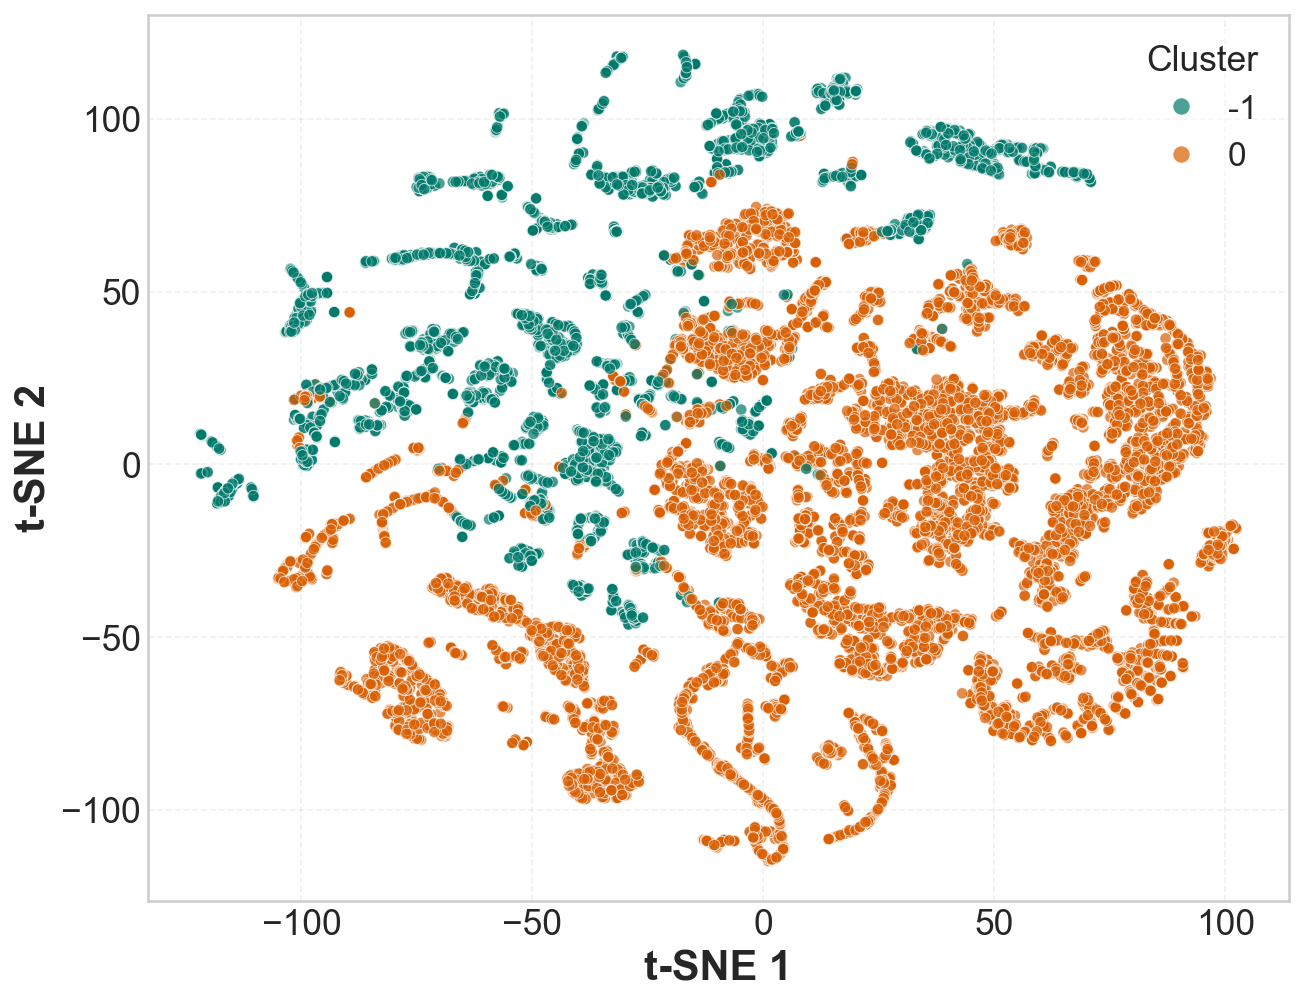

In [23]:
def map_function(val):
    if val >= 0:
        return 0
    return -1
dbscan_labels_binary = map(map_function, dbscan_labels)
plot_tsne(X_train, list(dbscan_labels_binary), perplexity=30, filename='task4_tsne_dbscan_perplexity_30.png', title="Cluster")


Generating t-SNE plot with perplexity=30...


/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_96295/3957001464.py:22: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


Figure saved to: ../Plots/Task4/task4_tsne_true_binary_labels_perplexity_30.png


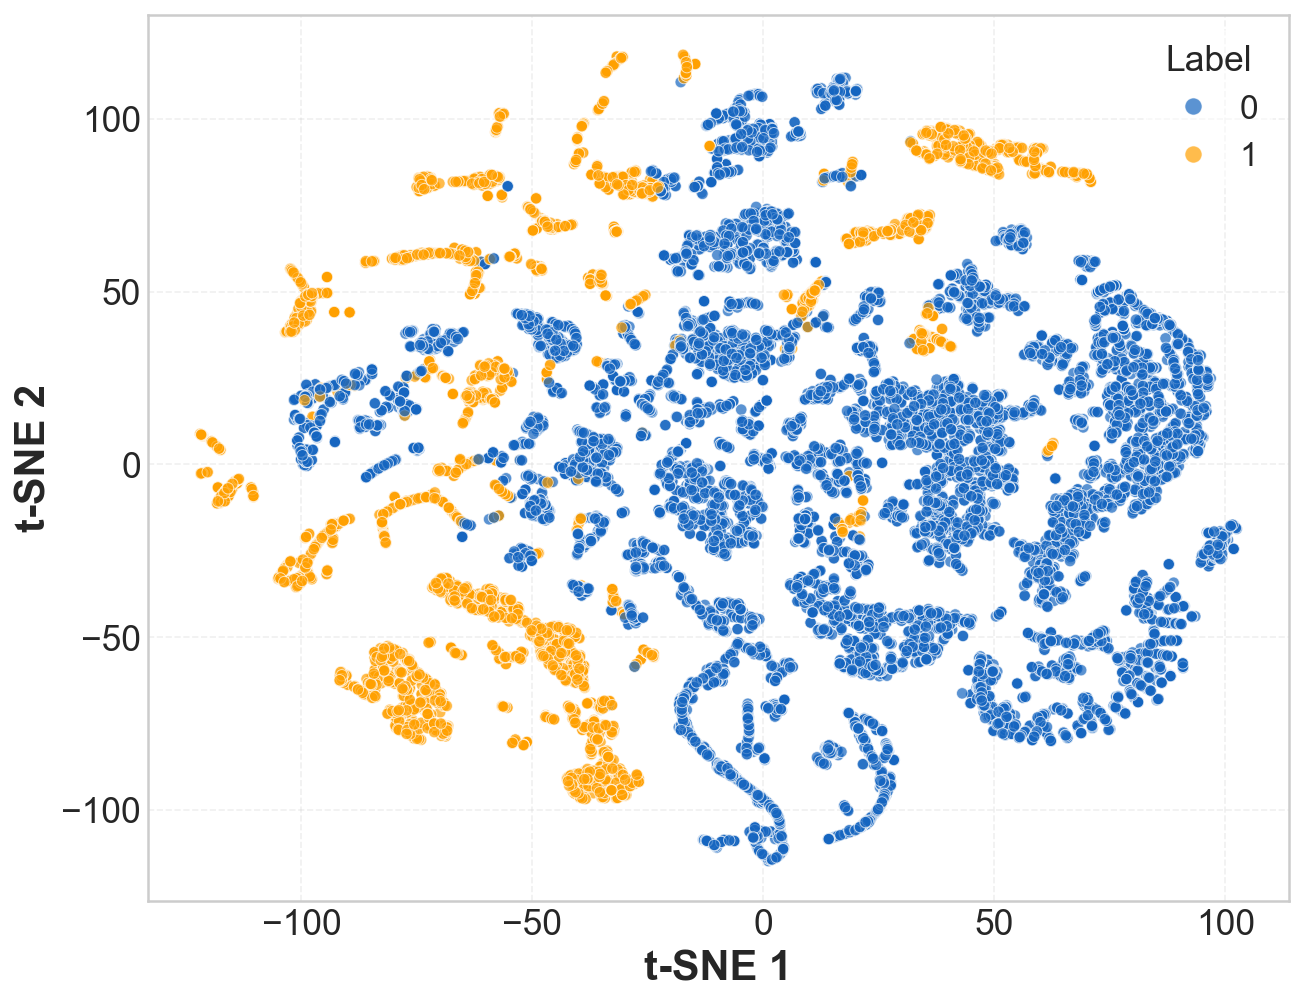

In [24]:
plot_tsne(X_train, list(y_train), perplexity=30, filename='task4_tsne_true_binary_labels_perplexity_30.png', title="Label")

### Question 4: DBSCAN Analysis
**Q: Create the clustering results using the entire training set (normal + anomalous) using the parameters min_points and epsilon. Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points (cross-reference with real attack labels)?**

**Answer:**
- **Noise Cluster (-1):** This cluster represents the outliers found by DBSCAN.
- **Composition:** 
    - dos: 586
    - normal: 2736
    - probe: 2073
    - r2l: 69
- **Conclusion:**
    - It contains **normal points**, that are False Positives (normal data that looks like noise).
    - There are **anomalies in other clusters**, that DBSCAN failed to detect (False Negatives).
    - Typically, DBSCAN is good at finding "sparse" anomalies but might struggle if anomalies form dense clusters themselves (which would be grouped into a valid cluster instead of noise).

Then, we repeat the analysis considering less neighbors and min_points (the performance are worse).

In [25]:
# Take top 500 neighbours
sorted_cosine_matrix_top_500 = sorted_cosine_matrix[:, :500]
means = 1 - sorted_cosine_matrix_top_500.mean(axis=0)

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_selection_v2.png


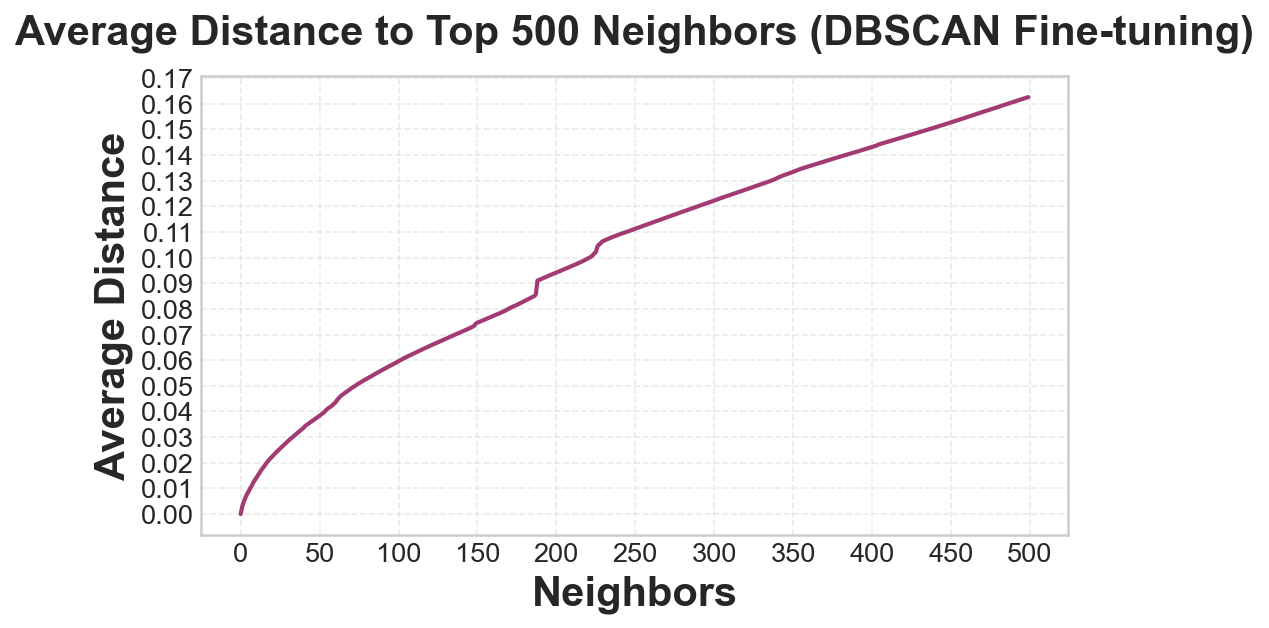

In [26]:
# Plot the mean distance for the top neighobours
plt.figure(figsize=(7, 4.5))
plt.plot(means, linewidth=2, color='#A23B72')
plt.xlabel('Neighbors')
plt.ylabel('Average Distance')
plt.xticks(np.arange(0, 501, 50), fontsize=13)
plt.yticks(np.arange(0, 0.18, 0.01), fontsize=13)
plt.title('Average Distance to Top 500 Neighbors (DBSCAN Fine-tuning)', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_selection_v2.png')
plt.show()


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.71      0.80      0.75     13448
           1       0.27      0.19      0.22      5383

    accuracy                           0.62     18831
   macro avg       0.49      0.49      0.49     18831
weighted avg       0.59      0.62      0.60     18831

Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v2.png


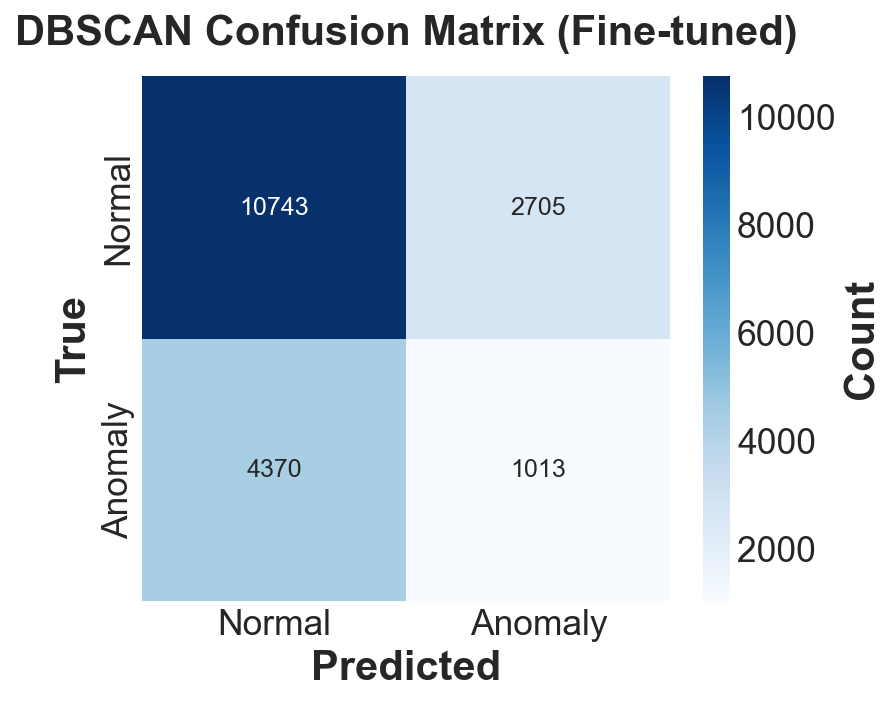

In [27]:
# Use DBSCAN with the epsilon and min_points gotten from the plot
dbscan = DBSCAN(eps=0.08, min_samples=180, metric="cosine")
dbscan_labels = dbscan.fit_predict(X_train)
y_pred_binary_dbscan = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_train, y_pred_binary_dbscan))
# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_train, y_pred_binary_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('DBSCAN Confusion Matrix (Fine-tuned)', pad=15)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
save_figure_for_report('task4_dbscan_confusion_matrix_v2.png')
plt.show()

Now we try to exclude outliers in the mean distance computation.

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_outlier_excluded.png


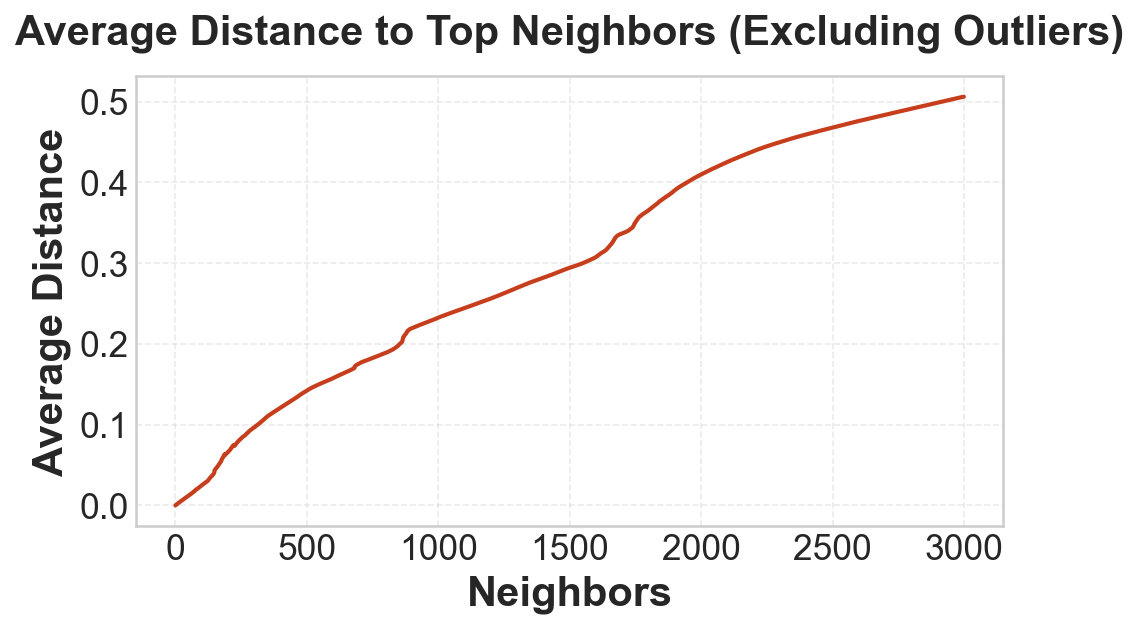

In [28]:
# Try to repeat excluding outliers in the mean computation
def compute_column_mean_excluding_outliers(matrix, threshold=1.5):
    """
    Compute mean of each column excluding outliers.

    Args:
        matrix: numpy array of shape (n_samples, n_features)
        threshold: IQR multiplier (1.5)

    Returns:
        means: array of column means excluding outliers
    """
    means = np.zeros(matrix.shape[1])

    for col in range(matrix.shape[1]):
        data = matrix[:, col]

        # IQR method: exclude values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        mask = (data >= lower_bound) & (data <= upper_bound)

        means[col] = np.mean(data[mask])

    return means

# Method 1: IQR (more robust to outliers)
means_iqr = 1 - compute_column_mean_excluding_outliers(sorted_cosine_matrix_top, 1.5)

plt.figure(figsize=(7, 4.5))
plt.plot(means_iqr, linewidth=2, color='#C73E1D')
plt.xlabel('Neighbors')
plt.ylabel('Average Distance')
plt.title('Average Distance to Top Neighbors (Excluding Outliers)', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_outlier_excluded.png')
plt.show()
# Not much difference from before

/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_96295/224429329.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_96295/3817335180.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)


Figure saved to: ../Plots/Task4/task4_cumulative_cosine_distances.png


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


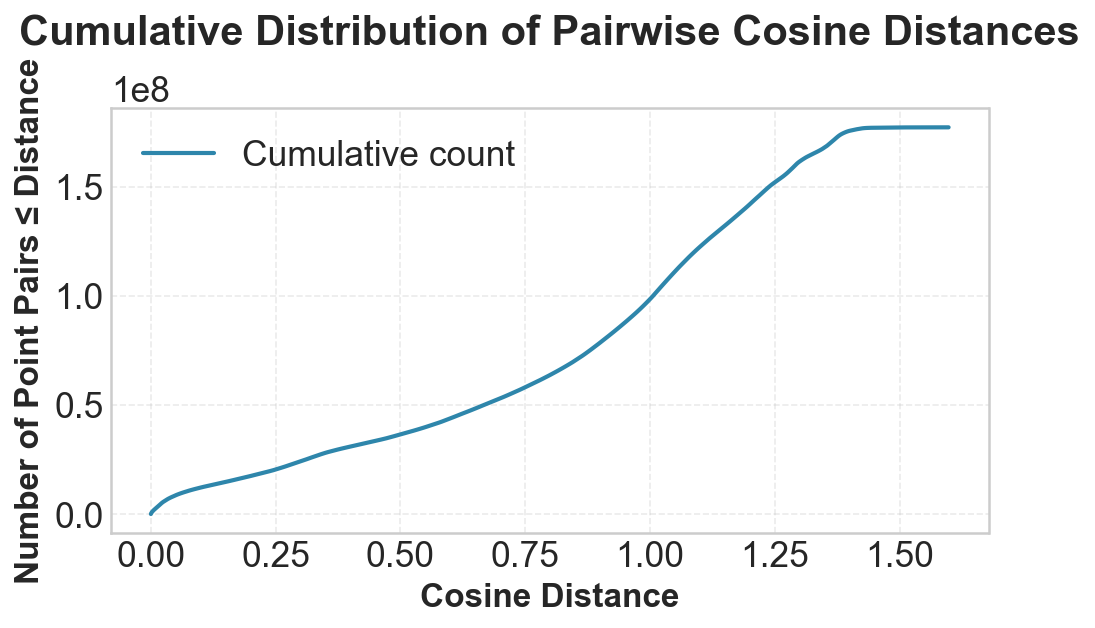

In [29]:
# Cumulative distribution of pairwise cosine distances
cosine_distances = 1.0 - cosine_matrix

upper_tri = cosine_distances[np.triu_indices_from(cosine_distances, k=1)]
sorted_distances = np.sort(upper_tri)
cumulative_counts = np.arange(1, len(sorted_distances) + 1)

plt.figure(figsize=(7, 4.5))
plt.plot(sorted_distances, cumulative_counts, label="Cumulative count", linewidth=2, color='#2E86AB')
plt.xlabel("Cosine Distance", fontsize=16)
plt.ylabel("Number of Point Pairs ≤ Distance", fontsize=16)
plt.title("Cumulative Distribution of Pairwise Cosine Distances", pad=15)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
save_figure_for_report('task4_cumulative_cosine_distances.png')
plt.show()

Finally, let's verify what happens if we choose min_points=10.

In [31]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10, algorithm='auto', n_jobs=-1)
nn.fit(X_train)

# Compute distances to 10 nearest neighbors (including the point itself)
distances, indices = nn.kneighbors(X_train)

In [ ]:
# Distance to the 9th nearest neighbor (not counting self, which is at index 0)
nineth_neighbor_distances = distances[:, 9]  # 10th closest = 10th real neighbor
# Now fourth_neighbor_distances[i] gives you the distance of point i to its 4th neighbor, to choose epsilon

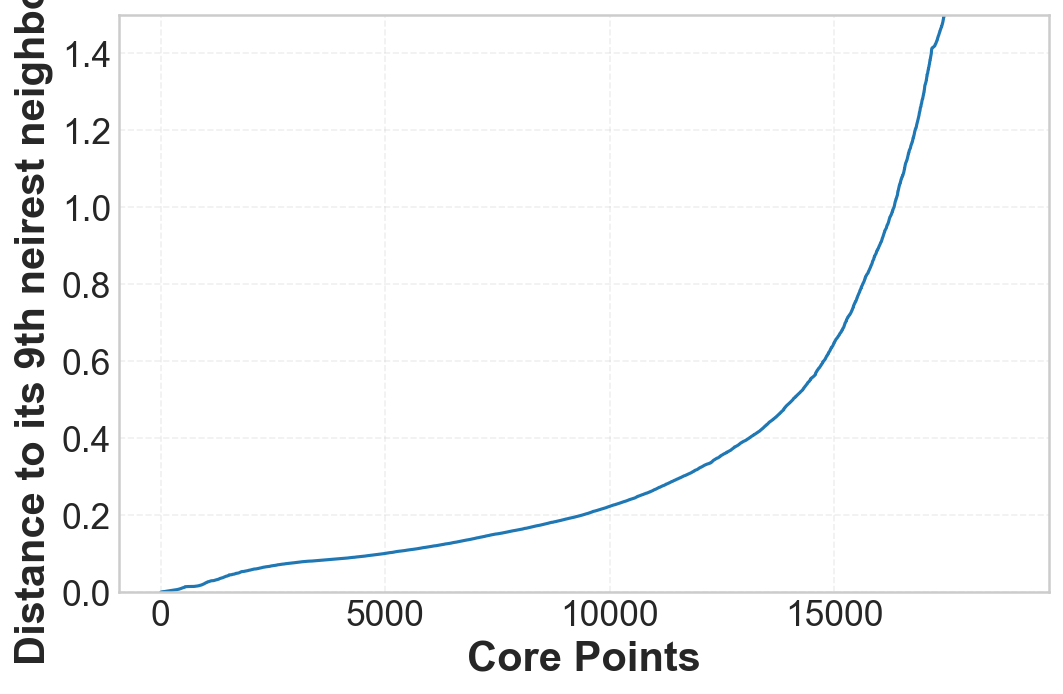

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(sorted( nineth_neighbor_distances))
plt.xlabel('Core Points')
plt.ylabel('Distance to its 9th neirest neighbour')
plt.ylim(0,1.5)
plt.grid(True)
plt.show()
plt.close()

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train)


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.70      0.62      0.66     13448
           1       0.26      0.34      0.30      5383

    accuracy                           0.54     18831
   macro avg       0.48      0.48      0.48     18831
weighted avg       0.58      0.54      0.55     18831



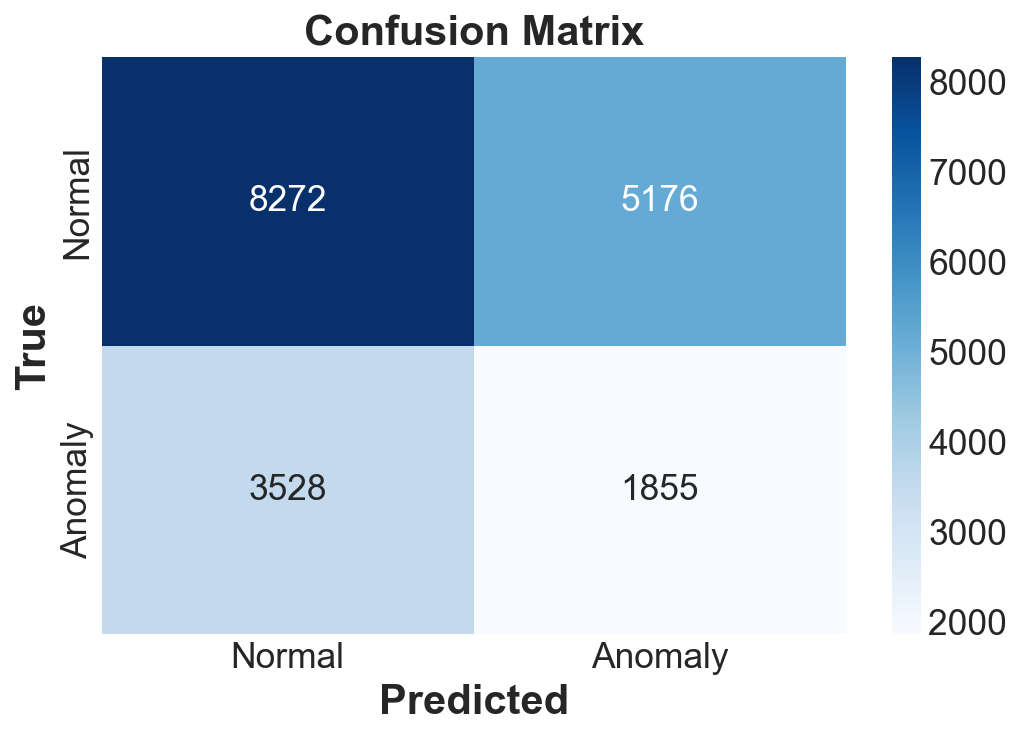

In [48]:
y_pred_binary_dbscan_9 = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_train, y_pred_binary_dbscan_9))
# Confusion matrix
cm = confusion_matrix(y_train, y_pred_binary_dbscan_9)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [52]:
dataset_dbscan_2 = pd.DataFrame()
dataset_dbscan_2['label'] = df_train['label'].map({0:'dos', 1:'normal', 2:'probe', 3:'r2l'})
dataset_dbscan_2['binary_label'] = y_train
dataset_dbscan_2['dbscan_label'] = dbscan_labels

print("Clusters", np.unique(dataset_dbscan_2['dbscan_label']))

noise_2 = dataset_dbscan_2[dataset_dbscan_2['dbscan_label'] == -1]
rest_2 = dataset_dbscan_2[dataset_dbscan_2['dbscan_label'] != -1]

clusters_2 = []
for i in range(0, 101):
    clusters_2.append(dataset_dbscan_2[dataset_dbscan_2['dbscan_label'] == i])

total = len(dataset_dbscan_2)
n_noise = len(noise_2)

print(f"Noise points: {n_noise} / {total} ({n_noise/total:.2%})\n")

print("Composition by multi-class 'label' in the noise cluster:")
print(noise_2['label'].value_counts().sort_index())
print("\nComposition by 'label' (percent) in the noise cluster:")
print((noise_2['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly) in the noise cluster:")
print(noise_2['binary_label'].value_counts())
print("\nComposition by binary_label (percent) in the noise cluster:")
print((noise_2['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

print("Composition by multi-class 'label' in the other clusters:")
print(rest_2['label'].value_counts().sort_index())
print("\nComposition by 'label' (percent) in the other clusters:")
print((rest_2['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly) in the other clusters:")
print(rest_2['binary_label'].value_counts())
print("\nComposition by binary_label (percent) in the other clusters:")
print((rest_2['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

for i in range(0,101):
    print(f"\nComposition by multi-class 'label' in cluster {i}:")
    print(clusters_2[i]['label'].value_counts().sort_index(), (clusters_2[i]['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

Clusters [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]
Noise points: 7031 / 18831 (37.34%)

Composition by multi-class 'label' in the noise cluster:
label
dos        805
normal    5176
probe     1000
r2l         50
Name: count, dtype: int64

Composition by 'label' (percent) in the noise cluster:
label
dos       11.45 %
normal    73.62 %
probe     14.22 %
r2l        0.71 %
Name: proportion, dtype: object

Composition by binary_label (0=normal, 1=anomaly) in the noise cluster:
binary_label
0    5176
1    1855
Name: count, dtype: int64

Composition by binary_label (percent) in the noise cluster:
binary_label
0    73.62 %
1    